# 10.3 注意力评分函数
由书可以知道，评分函数的输出结果，Softmax后，会作为注意力权重。

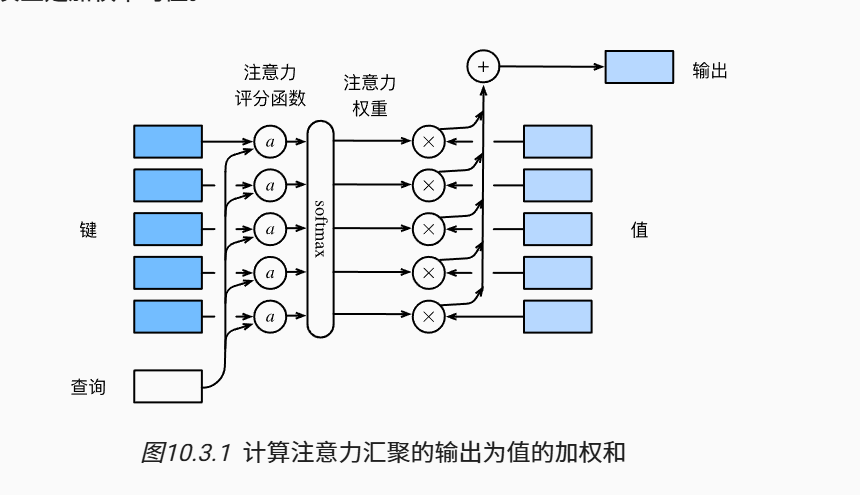

key和query都是训练集，同一个batch_size的训练数据之间的一种关系。
设$a$ 是注意力评分函数。

value是什么？

value就是这一个batch_size中的标签y。

具体注意力层的计算方法如下：

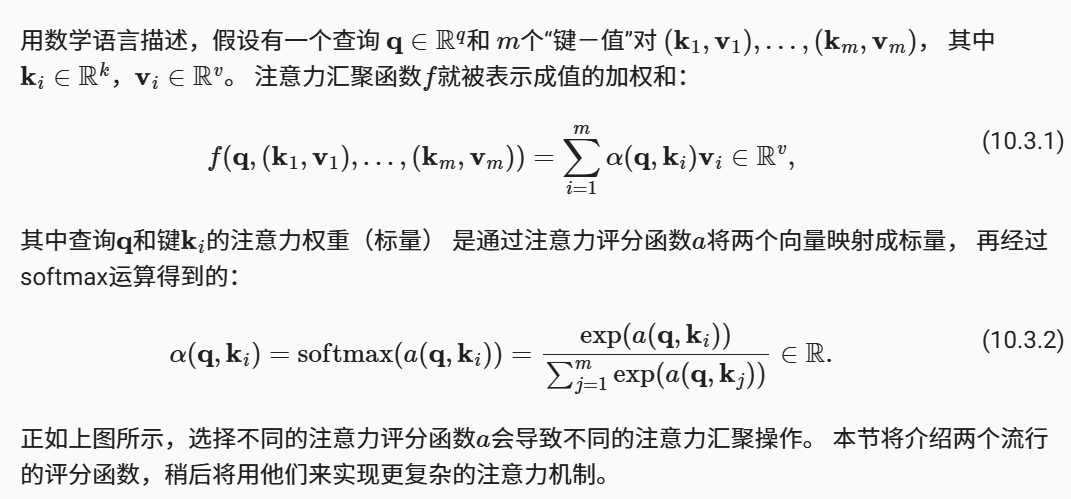



In [1]:
import math
import torch
from torch import nn 
from d2l import torch as d2l


# 10.3.1 mask Softmax 操作
mask主要在Transformer中的decoder层用到。

mask主要过滤掉一些信息，将没用的信息变为0.


In [2]:
def masked_softmax(X, valid_lens):
    """在最后一个维度上来进行mask，因为最后一个维度是feature"""
    # X: 3 维，valid_lens: 1或者2维, 表示样本的有效长度。
    # 比如，valid_lens = [2, 3, 1] ，表示这3个样本的有效维度分别是2 、3、1 
    if valid_lens is None:  # 不需要mask
        return nn.functional.softmax(X, dim=-1)  # 直接在feature这个维度上Softmax
    else:
        # 正常进行mask
        shape = X.shape   # [batch_size，行数，列数]
        if valid_lens.dim() == 1:  # valid_lens的维度为1维向量
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])  # 将valid_lens中的
                                                                    # 每个元素重复shape[1]次
        else:  # mask的维度为2，展平
            valid_lens = valid_lens.reshape(-1)  
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6) 
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [4]:
# 考虑两个2 * 4 的样本，也就是batch_size = 2，每个batch_size中的样本为2 * 4
x = torch.rand(2, 2, 4)  # 表示batch_size = 2， seq = 2 ， Token维度为4
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5079, 0.4921, 0.0000, 0.0000],
         [0.4914, 0.5086, 0.0000, 0.0000]],

        [[0.3451, 0.3142, 0.3407, 0.0000],
         [0.3200, 0.3382, 0.3418, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3281, 0.3429, 0.3291, 0.0000]],

        [[0.6370, 0.3630, 0.0000, 0.0000],
         [0.2363, 0.1757, 0.2562, 0.3318]]])

# 缩放点积注意力 scaled dot-product attention
要求：query 和 key具有相同的长度d。

并且query和key中的所有向量的feature都是零均值和1方差的。
那么query和key的点积的均值为0， 方差为d。

为了确保无论向量长度如何，点积的方差在不考虑向量长度的情况下仍为1，我们将点积的结果除以$\sqrt(d)$

则scaled dot-product attention 评分函数为：

$$
\alpha (\vec q, \vec k) = \frac{\vec q ^ T \vec k }{\sqrt(d)}
$$

In [6]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)